# 1. Asignacion lineal

**Contexto del Problema:**

Una empresa de distribución maneja productos que deben ser enviados desde sus almacenes hacia distintas tiendas en diferentes ciudades. La empresa busca minimizar los costos de transporte asegurando que cada tienda reciba los productos desde el almacén más cercano o más conveniente económicamente.

Supongamos que la empresa tiene 3 almacenes (W1, W2, W3) y 4 tiendas (T1, T2, T3, T4). Los costos de transporte por unidad de producto de cada almacén a cada tienda son los siguientes:

|   | T1 | T2 | T3 | T4 |
|---|---|---|---|---|
| W1 | 8 | 6 | 10 | 9 |
| W2 | 9 | 12 | 13 | 7 |
| W3 | 14 | 9 | 16 | 5 |

Cada tienda tiene una demanda específica de unidades de producto, y cada almacén tiene una cantidad limitada de unidades disponibles para enviar. El objetivo es asignar de qué almacén debe surtirse cada tienda para minimizar el costo total de transporte, cumpliendo con las demandas de las tiendas y no excediendo la capacidad de los almacenes.

**Formulación del Modelo de Asignación:**

Definamos las variables y parámetros:

- `x_ij`: número de unidades de productos enviadas del almacén i a la tienda j.
- `c_ij`: costo de transporte por unidad del almacén i a la tienda j.
- `d_j`: demanda de la tienda j.
- `s_i`: suministro disponible en el almacén i.

El modelo busca minimizar la función objetivo, que es el costo total de transporte:

$ \text{Minimizar} \sum_{i,j} c_{ij} x_{ij} $

Sujeto a las siguientes restricciones:

1. **Satisfacción de la Demanda:** Cada tienda debe recibir su demanda exacta desde los almacenes.
   $ \sum_{i} x_{ij} = d_j \quad \forall j $

2. **Restricciones de Suministro:** Cada almacén no puede enviar más productos de los que tiene disponibles.
   $ \sum_{j} x_{ij} \leq s_i \quad \forall i $

3. **No Negatividad y Enteros:** Las unidades enviadas deben ser números enteros y no pueden ser negativas.
   $ x_{ij} \geq 0 \quad \forall i,j $
   Y, si se requiere que las asignaciones sean en unidades enteras, entonces:
  $ x_{ij} \in \mathbb{Z}^+ \cup \{0\} \quad \forall i,j $

Este modelo de asignación ayudará a la empresa a determinar la manera más eficiente de distribuir sus productos desde los almacenes hasta las tiendas, optimizando los costos de transporte mientras se satisfacen las demandas de las tiendas y las limitaciones de suministro de los almacenes.

In [ ]:
!pip install pyomo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.3 MB/s eta 0:00:00


In [ ]:
from pyomo.environ import *
import os

# Definir almacenes y tiendas
almacenes = ['W1', 'W2', 'W3']
tiendas = ['T1', 'T2', 'T3', 'T4']

# Costos de transporte por unidad desde cada almacén a cada tienda
costos_transporte = {
    ('W1', 'T1'): 8, ('W1', 'T2'): 6, ('W1', 'T3'): 10, ('W1', 'T4'): 9,
    ('W2', 'T1'): 9, ('W2', 'T2'): 12, ('W2', 'T3'): 13, ('W2', 'T4'): 7,
    ('W3', 'T1'): 14, ('W3', 'T2'): 9, ('W3', 'T3'): 16, ('W3', 'T4'): 5
}

# Demanda de cada tienda
demanda = {'T1': 20, 'T2': 15, 'T3': 30, 'T4': 25}

# Suministro disponible en cada almacén
suministro = {'W1': 40, 'W2': 60, 'W3': 50}

# Configurar el correo electrónico para NEOS
os.environ['NEOS_EMAIL'] = 'jorgei.romerog@utadeo.edu.co'

# Modelo
modelo = ConcreteModel()

# Variables de decisión: unidades enviadas desde almacén i a tienda j
modelo.x = Var([(i, j) for i in almacenes for j in tiendas], domain=NonNegativeIntegers)

# Función objetivo: Minimizar el costo total de transporte
modelo.cost = Objective(expr=sum(costos_transporte[i, j] * modelo.x[i, j] for i in almacenes for j in tiendas), sense=minimize)

# Restricciones de demanda
modelo.demanda = ConstraintList()
for j in tiendas:
    modelo.demanda.add(sum(modelo.x[i, j] for i in almacenes) == demanda[j])

# Restricciones de suministro
modelo.suministro = ConstraintList()
for i in almacenes:
    modelo.suministro.add(sum(modelo.x[i, j] for j in tiendas) <= suministro[i])

# Resolver el modelo usando NEOS
solver_manager = SolverManagerFactory('neos')
resultados = solver_manager.solve(modelo, opt='cplex')

# Imprimir los resultados
print("Costo total de transporte mínimo:", modelo.cost())

for i in almacenes:
    for j in tiendas:
        if modelo.x[i, j].value > 0:
            print(f"Del almacén {i} a la tienda {j}: {modelo.x[i, j].value} unidades")


Costo total de transporte mínimo: 710.0
Del almacén W1 a la tienda T2: 15.0 unidades
Del almacén W1 a la tienda T3: 25.0 unidades
Del almacén W2 a la tienda T1: 20.0 unidades
Del almacén W2 a la tienda T3: 5.0 unidades
Del almacén W3 a la tienda T4: 25.0 unidades


# 2. TSP

### **Problema: Optimización de la Ruta de Viaje Entre Ciudades**

Consideramos un conjunto de cuatro ciudades etiquetadas como A, B, C, y D. Nos enfrentamos al desafío de planificar un viaje que comience en una ciudad de origen, visite cada una de las otras ciudades exactamente una vez y luego regrese a la ciudad de origen, minimizando el costo total del viaje. Los costos de viaje entre cada par de ciudades son simétricos y se presentan en la siguiente tabla:

|   | A | B | C | D |
|---|---|---|---|---|
| A | - | 5 | 6 | 4 |
| B | 5 | - | 3 | 2 |
| C | 6 | 3 | - | 5 |
| D | 4 | 2 | 5 | - |

#### **Objetivo:**

El objetivo es identificar la ruta más eficiente que cumpla con los requisitos anteriores, asegurando el menor costo de viaje total.

#### **Formulación del Modelo MTZ:**

Para abordar este problema, empleamos la formulación MTZ, una técnica de programación lineal entera que nos ayuda a encontrar la solución óptima. Definimos las siguientes variables y restricciones:

- **Variables:**
  - \(x_{ij}\): variable binaria que toma el valor de 1 si se decide viajar de la ciudad \(i\) a la ciudad \(j\), y 0 en caso contrario.
  - \(u_i\): variable entera que representa el orden en el que se visita la ciudad \(i\), ayudando a evitar ciclos subóptimos o subtours.

- **Restricciones:**
  1. **Unicidad de Salida y Llegada:** Para asegurar que desde y hacia cada ciudad se viaje exactamente una vez, para todas las ciudades \(i \neq j\):
     \[x_{ij} + x_{ji} = 1\]
  2. **Restricciones de MTZ para Evitar Subtours:** Estas restricciones aseguran que no se formen ciclos que no incluyan a todas las ciudades, facilitando la visita a cada ciudad una única vez antes de regresar a la ciudad de origen. Para cada par de ciudades \(i\) y \(j\), donde \(i \neq j\) y \(N\) es el número total de ciudades:
     \[u_i - u_j + N \cdot x_{ij} \leq N-1\]

- **Dominio de las Variables:**
  - Cada \(u_i\) debe ser un entero positivo dentro del conjunto \(\{1, 2, 3, \ldots, N\}\).
  - Cada \(x_{ij}\) es una variable binaria, es decir, \(\{0, 1\}\).

#### **Solución:**

La aplicación de este modelo nos permite calcular la ruta más corta que cumple con el requisito de visitar todas las ciudades una vez, optimizando el costo total del viaje. Utilizamos herramientas de programación lineal entera para resolver este modelo y obtener la ruta óptima.



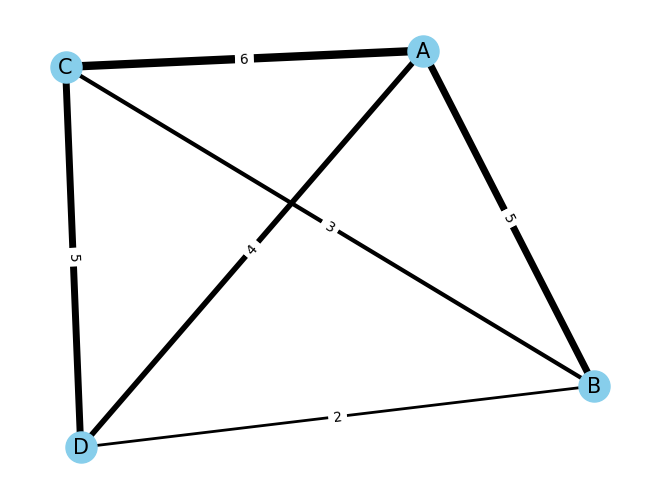

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
cities = ['A', 'B', 'C', 'D']
distances = {
    ('A', 'B'): 5, ('A', 'C'): 6, ('A', 'D'): 4,
    ('B', 'A'): 5, ('B', 'C'): 3, ('B', 'D'): 2,
    ('C', 'A'): 6, ('C', 'B'): 3, ('C', 'D'): 5,
    ('D', 'A'): 4, ('D', 'B'): 2, ('D', 'C'): 5
}

G = nx.Graph()

for city in cities:
    G.add_node(city)


for key, value in distances.items():
    G.add_edge(key[0], key[1], weight=value)

pos = nx.spring_layout(G)  # pos = nx.nx_agraph.graphviz_layout(G)
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]

nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=15, width=weights)
nx.draw_networkx_edge_labels(G, pos, edge_labels=distances)

plt.show()

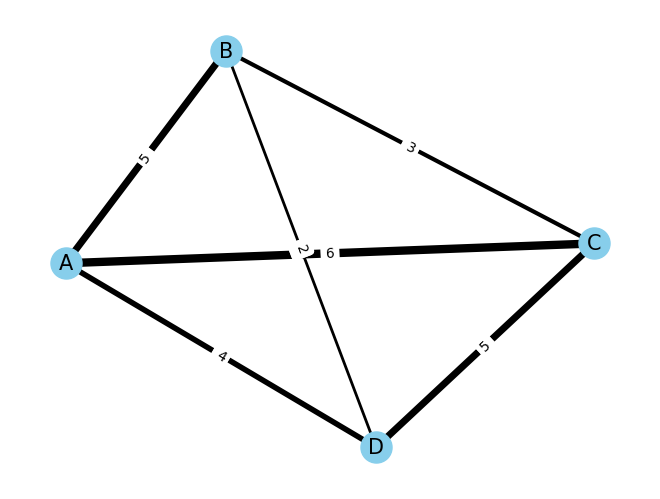

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
cities = ['A', 'B', 'C', 'D']
distances = {
    ('A', 'B'): 5, ('A', 'C'): 6, ('A', 'D'): 4,
    ('B', 'A'): 5, ('B', 'C'): 3, ('B', 'D'): 2,
    ('C', 'A'): 6, ('C', 'B'): 3, ('C', 'D'): 5,
    ('D', 'A'): 4, ('D', 'B'): 2, ('D', 'C'): 5
}

G = nx.Graph()

for city in cities:
    G.add_node(city)


for key, value in distances.items():
    G.add_edge(key[0], key[1], weight=value)

pos = nx.spring_layout(G)  # pos = nx.nx_agraph.graphviz_layout(G)
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]

nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=15, width=weights)
nx.draw_networkx_edge_labels(G, pos, edge_labels=distances)

plt.show()

In [ ]:
cities = ['A', 'B', 'C', 'D']
distances = {
    ('A', 'B'): 5, ('A', 'C'): 6, ('A', 'D'): 4,
    ('B', 'A'): 5, ('B', 'C'): 3, ('B', 'D'): 2,
    ('C', 'A'): 6, ('C', 'B'): 3, ('C', 'D'): 5,
    ('D', 'A'): 4, ('D', 'B'): 2, ('D', 'C'): 5,
    ('A', 'A'): 1000, ('B', 'B'): 1000, ('C', 'C'): 1000,('D', 'D'): 1000
}

In [ ]:
!pip install pyomo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.0 MB/s eta 0:00:00


In [ ]:
from pyomo.environ import *
import os
cities = ['A', 'B', 'C', 'D']
distances = {
    ('A', 'B'): 5, ('A', 'C'): 6, ('A', 'D'): 4,
    ('B', 'A'): 5, ('B', 'C'): 3, ('B', 'D'): 2,
    ('C', 'A'): 6, ('C', 'B'): 3, ('C', 'D'): 5,
    ('D', 'A'): 4, ('D', 'B'): 2, ('D', 'C'): 5,
    ('A', 'A'): 1000, ('B', 'B'): 1000, ('C', 'C'): 1000,('D', 'D'): 1000
}
os.environ['NEOS_EMAIL']='jorgei.romerog@utadeo.edu.co'
mtz=ConcreteModel()
i=cities
j=cities
U=i[1:]
d=distances
mtz.x=Var(i,j,domain=Binary)
mtz.u=Var(U,domain=NonNegativeIntegers)
mtz.obj=Objective(expr=sum(d[m,n]*mtz.x[m,n] for m in i for n in j),sense=minimize)
mtz.fila=ConstraintList()
for m in i:
  mtz.fila.add(sum(mtz.x[m,n] for n in j)==1)
mtz.columna=ConstraintList()
for n in j:
  mtz.columna.add(sum(mtz.x[m,n] for m in i )==1)
#restriccion mtz ui-uj + n*xij <=n-1 i,j!=1
mtz.subtour=ConstraintList()
for m in U:
  for n in U:
    mtz.subtour.add(mtz.u[m]-mtz.u[n]+4*mtz.x[m,n]<=3)

solver_manager=SolverManagerFactory('neos')
resultados=solver_manager.solve(mtz,solver='cplex')

print("la minima distancia es", mtz.obj())

for m in i:
  for n in j:
        if mtz.x[m,n].value == 1:
          print(m,n,mtz.x[m,n]())

la minima distancia es 15.0
A C 1.0
B D 1.0
C B 1.0
D A 1.0


In [ ]:
from pyomo.environ import *
import os
cities = ['A', 'B', 'C', 'D']
distances = {
    ('A', 'B'): 5, ('A', 'C'): 6, ('A', 'D'): 4,
    ('B', 'A'): 5, ('B', 'C'): 3, ('B', 'D'): 2,
    ('C', 'A'): 6, ('C', 'B'): 3, ('C', 'D'): 5,
    ('D', 'A'): 4, ('D', 'B'): 2, ('D', 'C'): 5,
    ('A', 'A'): 1000, ('B', 'B'): 1000, ('C', 'C'): 1000,('D', 'D'): 1000
}
os.environ['NEOS_EMAIL']='jorgei.romerog@utadeo.edu.co'
mtz=ConcreteModel()
i=cities
j=cities
U=i[1:]
d=distances
mtz.x=Var(i,j,domain=Binary)
mtz.u=Var(U,domain=NonNegativeIntegers)
mtz.obj=Objective(expr=sum(d[m,n]*mtz.x[m,n] for m in i for n in j),sense=minimize)
mtz.fila=ConstraintList()
for m in i:
  mtz.fila.add(sum(mtz.x[m,n] for n in j)==1)
mtz.columna=ConstraintList()
for n in j:
  mtz.columna.add(sum(mtz.x[m,n] for m in i )==1)
#restriccion mtz ui-uj + n*xij <=n-1 i,j!=1
mtz.subtour=ConstraintList()
for m in U:
  for n in U:
    mtz.subtour.add(mtz.u[m]-mtz.u[n]+4*mtz.x[m,n]<=3)

solver_manager=SolverManagerFactory('neos')
resultados=solver_manager.solve(mtz,solver='cplex')

print("la minima distancia es", mtz.obj())

for m in i:
  for n in j:
          print(m,n,mtz.x[m,n]())

la minima distancia es 15.0
A A 0.0
A B 0.0
A C 1.0
A D 0.0
B A 0.0
B B 0.0
B C 0.0
B D 1.0
C A 0.0
C B 1.0
C C 0.0
C D 0.0
D A 1.0
D B 0.0
D C 0.0
D D 0.0


In [ ]:
from pyomo.environ import *
import os

cities = ['A', 'B', 'C', 'D']
distances = {
    ('A', 'B'): 5, ('A', 'C'): 6, ('A', 'D'): 4,
    ('B', 'A'): 5, ('B', 'C'): 3, ('B', 'D'): 2,
    ('C', 'A'): 6, ('C', 'B'): 3, ('C', 'D'): 5,
    ('D', 'A'): 4, ('D', 'B'): 2, ('D', 'C'): 5,
    ('A', 'A'): 1000, ('B', 'B'): 1000, ('C', 'C'): 1000,('D', 'D'): 1000
}

os.environ['NEOS_EMAIL'] = 'jorgei.romerog@utadeo.edu.co'

mtz = ConcreteModel()
i = cities
j = cities
U = i[1:]
d = distances

mtz.x = Var(i, j, domain=Binary)
mtz.u = Var(U, domain=NonNegativeIntegers)
mtz.obj = Objective(expr=sum(d[m, n] * mtz.x[m, n] for m in i for n in j), sense=minimize)
mtz.fila = ConstraintList()
for m in i:
    mtz.fila.add(sum(mtz.x[m, n] for n in j) == 1)
mtz.columna = ConstraintList()
for n in j:
    mtz.columna.add(sum(mtz.x[m, n] for m in i) == 1)

# Restriccion mtz ui-uj + n*xij <=n-1 i,j!=1
mtz.subtour = ConstraintList()
for m in U:
    for n in U:
        mtz.subtour.add(mtz.u[m] - mtz.u[n] + 4 * mtz.x[m, n] <= 3)

solver_manager = SolverManagerFactory('neos')
resultados = solver_manager.solve(mtz, solver='cplex')

print("La mínima distancia es", mtz.obj())

ruta = []
current_city = 'A'  # Inicia en la ciudad 'A'

while True:
    ruta.append(current_city)
    for n in j:
        if mtz.x[current_city, n].value == 1:
            distancia = distances[(current_city, n)]
            current_city = n
            break
    if current_city == 'A':
        break

ruta.append('A')  # Agrega la ciudad 'A' al final de la ruta

print("Ruta secuencial:", ' -> '.join(ruta))


La mínima distancia es 15.0
Ruta secuencial: A -> C -> B -> D -> A


In [ ]:
from pyomo.environ import *
import os

cities = ['A', 'B', 'C', 'D']
distances = {
    ('A', 'B'): 5, ('A', 'C'): 6, ('A', 'D'): 4,
    ('B', 'A'): 5, ('B', 'C'): 3, ('B', 'D'): 2,
    ('C', 'A'): 6, ('C', 'B'): 3, ('C', 'D'): 5,
    ('D', 'A'): 4, ('D', 'B'): 2, ('D', 'C'): 5,
    ('A', 'A'): 1000, ('B', 'B'): 1000, ('C', 'C'): 1000,('D', 'D'): 1000
}

os.environ['NEOS_EMAIL'] = 'jorgei.romerog@utadeo.edu.co'

mtz = ConcreteModel()
i = cities
j = cities
U = i[1:]
d = distances

mtz.x = Var(i, j, domain=Binary)
mtz.u = Var(U, domain=NonNegativeIntegers)
mtz.obj = Objective(expr=sum(d[m, n] * mtz.x[m, n] for m in i for n in j), sense=minimize)
mtz.fila = ConstraintList()
for m in i:
    mtz.fila.add(sum(mtz.x[m, n] for n in j) == 1)
mtz.columna = ConstraintList()
for n in j:
    mtz.columna.add(sum(mtz.x[m, n] for m in i) == 1)

# Restriccion mtz ui-uj + n*xij <=n-1 i,j!=1
mtz.subtour = ConstraintList()
for m in U:
    for n in U:
        mtz.subtour.add(mtz.u[m] - mtz.u[n] + 4 * mtz.x[m, n] <= 3)

solver_manager = SolverManagerFactory('neos')
resultados = solver_manager.solve(mtz, solver='cplex')

print("La mínima distancia es", mtz.obj())

ruta = []
current_city = 'A'  # Inicia en la ciudad 'A'
total_distance = 0

while True:
    ruta.append(current_city)
    for n in j:
        if mtz.x[current_city, n].value == 1:
            distancia = distances[(current_city, n)]
            total_distance += distancia
            current_city = n
            break
    if current_city == 'A':
        break

ruta.append('A')  # Agrega la ciudad 'A' al final de la ruta
ruta_distance = [distances[(ruta[i], ruta[i+1])] for i in range(len(ruta)-1)]  # Distancias entre ciudades

print("Ruta secuencial:", ' -> '.join(ruta))
print("Distancias recorridas:", ruta_distance)
print("Distancia total:", total_distance)


La mínima distancia es 15.0
Ruta secuencial: A -> C -> B -> D -> A
Distancias recorridas: [6, 3, 2, 4]
Distancia total: 15


In [ ]:
from simanneal import Annealer

import random

import math




# Datos del problema

distances = {

    ('A', 'B'): 5, ('A', 'C'): 6, ('A', 'D'): 4,

    ('B', 'A'): 5, ('B', 'C'): 3, ('B', 'D'): 2,

    ('C', 'A'): 6, ('C', 'B'): 3, ('C', 'D'): 5,

    ('D', 'A'): 4, ('D', 'B'): 2, ('D', 'C'): 5

}




# Definición de la clase

class TSPProblem(Annealer):




    def move(self):

        """Intercambia dos ciudades en la ruta."""

        a = random.randint(0, len(self.state) - 1)

        b = random.randint(0, len(self.state) - 1)

        self.state[a], self.state[b] = self.state[b], self.state[a]




    def energy(self):

        """Calcula la longitud total de la ruta."""

        e = 0

        for i in range(len(self.state)):

            e += distances[(self.state[i-1], self.state[i])]

        return e


# Crear el problema e inicializar el estado

init_state = list('ABCD')

random.shuffle(init_state)

problem = TSPProblem(init_state)

# Intentar resolver el problema mediante recocido simulado

problem.set_schedule(problem.auto(minutes=1)) # set the schedule (temperature)
state, e = problem.anneal()

# Imprimir la solución

print("%s: %i" % (state, e))


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature        Energy    Accept   Improve     Elapsed   Remaining


['D', 'B', 'C', 'A']: 15
